## Installing packages

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'train.csv', 'sample_submission.csv']


## Loading Dataset (train and test)

In [2]:
dataset = pd.read_csv('../input/train.csv')
dataset.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
dataset.shape

(42000, 785)

In [4]:
submission_dataset = pd.read_csv('../input/test.csv')
submission_dataset.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
submission_dataset.shape

(28000, 784)

### Frequency Distribution of Each Label

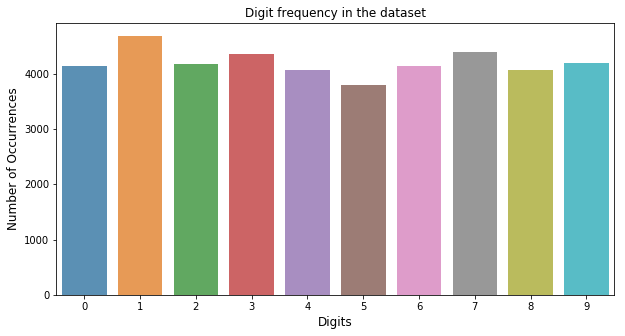

In [6]:
label_counts = dataset['label'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(label_counts.index, label_counts.values, alpha=0.8)
plt.title('Digit frequency in the dataset')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Digits', fontsize=12)
plt.show()

### Train-Test Split

In [7]:
def create_train_test_set_tensor(dataset, batch_size = 32):

    labels = dataset['label'].values
    digit_dataset = dataset.drop(['label'],axis=1)
    digit_dataset = digit_dataset.values
    digit_dataset = digit_dataset/255.0

    X_train, X_test, Y_train, Y_test = train_test_split(digit_dataset, labels, test_size=0.2, random_state=42)

    X_train = torch.from_numpy(X_train)
    Y_train = torch.from_numpy(Y_train).type(torch.LongTensor)

    X_test = torch.from_numpy(X_test)
    Y_test = torch.from_numpy(Y_test).type(torch.LongTensor)

    train = torch.utils.data.TensorDataset(X_train, Y_train)
    test = torch.utils.data.TensorDataset(X_test, Y_test)


    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size)
    
    return train_loader, test_loader

In [8]:
train_loader, test_loader = create_train_test_set_tensor(dataset)

## Multi-Layer Perceptron

In [9]:
## TODO: Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # number of hidden nodes in each layer (512)
        hidden_1 = 512
        hidden_2 = 256
        hidden_3 = 128
        # linear layer (784 -> 1 hidden node)
        self.fc1 = nn.Linear(28 * 28, hidden_1)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        # linear layer (n_hidden -> hidden_3)
        self.fc3 = nn.Linear(hidden_2, hidden_3)
        # linear layer (n_hidden -> 10)
        self.fc4 = nn.Linear(hidden_3, 10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc3(x))
        # add dropout layer
        x = self.dropout(x)
        # add output layer
        x = self.fc4(x)
        return x

In [10]:
def train_model(model, train_loader, n_epochs=30):
    # specify loss function
    criterion = nn.CrossEntropyLoss()

    # specify optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)        

    model.train() # prep model for training

    for epoch in range(n_epochs):
        # monitor training loss
        train_loss = 0.0

        ###################
        # train the model #
        ###################
        for data, target in train_loader:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data.float())
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*data.size(0)

        # print training statistics 
        # calculate average loss over an epoch
        train_loss = train_loss/len(train_loader.sampler)

        print('Epoch: {} \tTraining Loss: {:.6f}'.format( epoch+1, train_loss))
        
    return model
    

In [11]:
# initialize the NN
mlp_model = Net()
print(mlp_model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)


In [12]:
mlp_model = train_model(mlp_model, train_loader)

Epoch: 1 	Training Loss: 0.640126
Epoch: 2 	Training Loss: 0.194176
Epoch: 3 	Training Loss: 0.134473
Epoch: 4 	Training Loss: 0.102461
Epoch: 5 	Training Loss: 0.083047
Epoch: 6 	Training Loss: 0.068659
Epoch: 7 	Training Loss: 0.058483
Epoch: 8 	Training Loss: 0.051540
Epoch: 9 	Training Loss: 0.047360
Epoch: 10 	Training Loss: 0.040723
Epoch: 11 	Training Loss: 0.036316
Epoch: 12 	Training Loss: 0.030301
Epoch: 13 	Training Loss: 0.029353
Epoch: 14 	Training Loss: 0.025547
Epoch: 15 	Training Loss: 0.024514
Epoch: 16 	Training Loss: 0.023739
Epoch: 17 	Training Loss: 0.018056
Epoch: 18 	Training Loss: 0.021316
Epoch: 19 	Training Loss: 0.020029
Epoch: 20 	Training Loss: 0.017549
Epoch: 21 	Training Loss: 0.013786
Epoch: 22 	Training Loss: 0.016423
Epoch: 23 	Training Loss: 0.013711
Epoch: 24 	Training Loss: 0.014860
Epoch: 25 	Training Loss: 0.012500
Epoch: 26 	Training Loss: 0.011965
Epoch: 27 	Training Loss: 0.012354
Epoch: 28 	Training Loss: 0.010736
Epoch: 29 	Training Loss: 0.0

In [13]:
# torch.save(model.state_dict(), 'model.pt')

In [14]:
def test_model(model, test_loader):
        # specify loss function
    criterion = nn.CrossEntropyLoss()

    # specify optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)  
    # initialize lists to monitor test loss and accuracy
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model.eval() # prep model for *evaluation*

    for data, target in test_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.float())
        # calculate the loss
        loss = criterion(output, target)
        # update test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(len(target)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # calculate and print avg test loss
    test_loss = test_loss/len(test_loader.sampler)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                str(i), 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

In [15]:
test_model(mlp_model, test_loader)

Test Loss: 0.100834

Test Accuracy of     0: 99% (811/816)
Test Accuracy of     1: 99% (903/909)
Test Accuracy of     2: 96% (818/846)
Test Accuracy of     3: 95% (895/937)
Test Accuracy of     4: 97% (820/839)
Test Accuracy of     5: 97% (682/702)
Test Accuracy of     6: 99% (778/785)
Test Accuracy of     7: 98% (882/893)
Test Accuracy of     8: 97% (814/835)
Test Accuracy of     9: 96% (809/838)

Test Accuracy (Overall): 97% (8212/8400)


In [16]:
# sample_submission = pd.read_csv('../input/sample_submission.csv')
# sample_submission.head()

In [17]:
def submission_prediction(model, submission_dataset):

    submission_dataset = submission_dataset.values
    submission_dataset = submission_dataset/255.0
    submission_dataset_tensor = torch.from_numpy(submission_dataset)

    model.eval()

    submission_pred = []
    image_id = []

    for idx, data in enumerate(submission_dataset_tensor):

        pred_arr = model(data.float())        

        _, pred = torch.max(pred_arr,1)

        # submission.append((idx, pred.numpy()[0]))        
        submission_pred.append(pred.numpy()[0])
        image_id.append(idx+1)

    submission_df = pd.DataFrame({'ImageId': image_id, 'Label': submission_pred})    
    
    return submission_df

In [18]:
# submission_df_mlp = submission_prediction(mlp_model, submission_dataset)
# submission_df_mlp.head()

In [19]:
# submission_df_mlp.to_csv('submission.csv', index=False)

# Convolutional Neural Network

In [20]:
## TODO: Define the CNN architecture
class CNNet(nn.Module):
    def __init__(self):
        super(CNNet, self).__init__()        
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        
        # linear layer-1
        self.fc1 = nn.Linear(32 * 7 * 7, 512)
        self.relu3 = nn.ReLU()
        # linear layer-2
        self.fc2 = nn.Linear(512, 256)
        self.relu4 = nn.ReLU()
        # linear layer-3
        self.fc3 = nn.Linear(256, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.20)

    def forward(self, x):        
        # add hidden layer, with relu activation function
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), -1)
        # add dropout layer
        x = self.dropout(x)
        
        x = self.fc1(x)                
        x = self.relu3(x)
        # add dropout layer
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.relu4(x)
        # add dropout layer
        x = self.dropout(x)
        
        x = self.fc3(x)
        return x

In [21]:
cnn_model = CNNet()
print(cnn_model)

CNNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=512, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (relu4): ReLU()
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)


In [22]:
def train_model_cnn(model, train_loader, n_epochs=30):
    # specify loss function
    criterion = nn.CrossEntropyLoss()

    # specify optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)        

    model.train() # prep model for training

    for epoch in range(n_epochs):
        # monitor training loss
        train_loss = 0.0

        ###################
        # train the model #
        ###################
        for data, target in train_loader:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model((data.float()).view(32,1,28,28))
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*data.size(0)

        # print training statistics 
        # calculate average loss over an epoch
        train_loss = train_loss/len(train_loader.sampler)

        print('Epoch: {} \tTraining Loss: {:.6f}'.format( epoch+1, train_loss))
        
    return model
    

In [23]:
cnn_model = train_model_cnn(cnn_model, train_loader, n_epochs=30)

Epoch: 1 	Training Loss: 0.486310
Epoch: 2 	Training Loss: 0.107283
Epoch: 3 	Training Loss: 0.074983
Epoch: 4 	Training Loss: 0.060827
Epoch: 5 	Training Loss: 0.049391
Epoch: 6 	Training Loss: 0.041631
Epoch: 7 	Training Loss: 0.038460
Epoch: 8 	Training Loss: 0.032758
Epoch: 9 	Training Loss: 0.027365
Epoch: 10 	Training Loss: 0.026291
Epoch: 11 	Training Loss: 0.024508
Epoch: 12 	Training Loss: 0.021706
Epoch: 13 	Training Loss: 0.020749
Epoch: 14 	Training Loss: 0.019353
Epoch: 15 	Training Loss: 0.017566
Epoch: 16 	Training Loss: 0.018071
Epoch: 17 	Training Loss: 0.013980
Epoch: 18 	Training Loss: 0.015550
Epoch: 19 	Training Loss: 0.013871
Epoch: 20 	Training Loss: 0.012381
Epoch: 21 	Training Loss: 0.010966
Epoch: 22 	Training Loss: 0.013032
Epoch: 23 	Training Loss: 0.012660
Epoch: 24 	Training Loss: 0.009696
Epoch: 25 	Training Loss: 0.010802
Epoch: 26 	Training Loss: 0.011611
Epoch: 27 	Training Loss: 0.009991
Epoch: 28 	Training Loss: 0.009515
Epoch: 29 	Training Loss: 0.0

In [24]:
def test_model_cnn(model, test_loader):
        # specify loss function
    criterion = nn.CrossEntropyLoss()

    # specify optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)    
    # initialize lists to monitor test loss and accuracy
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model.eval() # prep model for *evaluation*
    cnt = 1
    for data, target in test_loader:
        # forward pass: compute predicted outputs by passing inputs to the model        
        
        output =  model((data.float()).view(data.size(0),1,28,28))                           
        
        # calculate the loss
        loss = criterion(output, target)
        # update test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(len(target)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # calculate and print avg test loss
    test_loss = test_loss/len(test_loader.sampler)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                str(i), 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

In [25]:
test_model_cnn(cnn_model, test_loader)

Test Loss: 0.037249

Test Accuracy of     0: 99% (808/816)
Test Accuracy of     1: 99% (905/909)
Test Accuracy of     2: 99% (839/846)
Test Accuracy of     3: 99% (928/937)
Test Accuracy of     4: 98% (828/839)
Test Accuracy of     5: 97% (687/702)
Test Accuracy of     6: 99% (783/785)
Test Accuracy of     7: 98% (884/893)
Test Accuracy of     8: 99% (830/835)
Test Accuracy of     9: 98% (826/838)

Test Accuracy (Overall): 99% (8318/8400)


In [26]:
def submission_prediction_cnn(model, submission_dataset):

    # submission_dataset = submission_dataset.values
    # submission_dataset = submission_dataset/255.0
    # submission_dataset_tensor = torch.from_numpy(submission_dataset)    
    model.eval()

    submission_pred = []
    image_id = []
    idx = 0
    for data in submission_dataset:

        pred_arr = model(data)        

        _, pred = torch.max(pred_arr,1)

        # submission.append((idx, pred.numpy()[0]))        
        submission_pred.append(pred.numpy()[0])
        image_id.append(idx+1)
        idx = idx + 1

    submission_df = pd.DataFrame({'ImageId': image_id, 'Label': submission_pred})    
    
    return submission_df

In [27]:
submission_dataset_test = submission_dataset.values
submission_dataset_test = submission_dataset_test.reshape([-1,1, 28, 28]).astype(np.float)
submission_dataset_test = submission_dataset_test/255.0
submission_dataset_test = np.expand_dims(submission_dataset_test, axis=1)
submission_dataset_test = torch.from_numpy(submission_dataset_test).float()

In [28]:
submission_df_cnn = submission_prediction_cnn(cnn_model, submission_dataset_test)
submission_df_cnn.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [29]:
submission_df_cnn.to_csv('submission.csv', index=False)

### Tutorials Used -
1. https://techblog.vn/digit-recognizer-with-pytorch
2. https://github.com/udacity/deep-learning-v2-pytorch/tree/master/convolutional-neural-networks
3. https://www.kaggle.com/kanncaa1/pytorch-tutorial-for-deep-learning-lovers